In [1]:
import altair as alt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')
import random
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    ShuffleSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.svm import SVC, SVR
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import pickle

In [2]:
X_train = pd.read_csv('../data/processed/training_feature.csv', index_col="index")
y_train = pd.read_csv('../data/processed/training_target.csv', index_col="index").loc[:,"TYPE"]

X_test = pd.read_csv('../data/processed/test_feature.csv', index_col="index")
y_test = pd.read_csv('../data/processed/test_target.csv', index_col="index").loc[:,"TYPE"]

In [3]:
file = open('../data/processed/preprocessor.p', 'rb')
preprocessor = pickle.load(file)

In [22]:
f1_scorer = make_scorer(f1_score, average='micro')

In [23]:
scoring_metrics = {
    "f1": f1_scorer,
}

In [24]:
results = {}

In [25]:
## Adopted from lecture notes of DSCI 571 and DSCI 573

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [26]:
pipe = make_pipeline(preprocessor, DummyClassifier())

results["dummy"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, cv=5, return_train_score=True, scoring=scoring_metrics
)

results = pd.DataFrame(results)
results.T

,fit_time,score_time,test_f1,train_f1
dummy,0.061 (+/- 0.010),0.042 (+/- 0.002),0.277 (+/- 0.000),0.277 (+/- 0.000)


In [28]:
pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, multi_class="ovr"))

results["Logistic Regression"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, cv=5, return_train_score=True, scoring=scoring_metrics
)

results = pd.DataFrame(results)
results.T

,fit_time,score_time,test_f1,train_f1
dummy,0.061 (+/- 0.010),0.042 (+/- 0.002),0.277 (+/- 0.000),0.277 (+/- 0.000)
Logistic Regression,6.664 (+/- 0.168),0.093 (+/- 0.003),0.472 (+/- 0.001),0.479 (+/- 0.001)


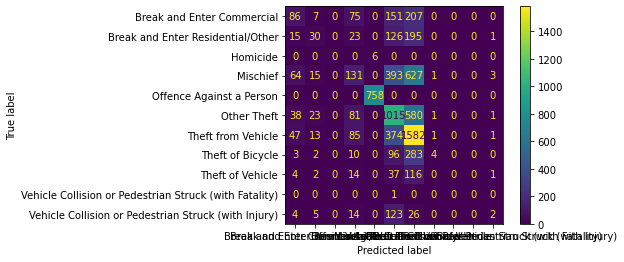

In [29]:
pipe.fit(X_train, y_train)
cm = ConfusionMatrixDisplay.from_estimator(
    pipe, X_test, y_test, values_format="d", display_labels=pipe.classes_
)

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pipe.predict(X_test), target_names=pipe.classes_))

                                                        precision    recall  f1-score   support

                            Break and Enter Commercial       0.33      0.16      0.22       526
                     Break and Enter Residential/Other       0.31      0.08      0.12       390
                                              Homicide       0.00      0.00      0.00         6
                                              Mischief       0.30      0.11      0.16      1234
                              Offence Against a Person       0.99      1.00      1.00       758
                                           Other Theft       0.44      0.58      0.50      1739
                                    Theft from Vehicle       0.44      0.75      0.55      2103
                                      Theft of Bicycle       0.57      0.01      0.02       398
                                      Theft of Vehicle       0.00      0.00      0.00       174
Vehicle Collision or Pedestrian Struck 

/Users/thomas/opt/miniconda3/envs/crime_predictor/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thomas/opt/miniconda3/envs/crime_predictor/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thomas/opt/miniconda3/envs/crime_predictor/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [31]:
y_preb_probs = pipe.predict_proba(X_test)
roc_auc_score(y_test, y_preb_probs, average="weighted", multi_class="ovr")

0.757924479978971

In [33]:
from sklearn.naive_bayes import GaussianNB

pipe = make_pipeline(preprocessor, GaussianNB())

results["GaussianNB"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, cv=5, return_train_score=True, scoring=scoring_metrics
)

results = pd.DataFrame(results)
results.T

,fit_time,score_time,test_f1,train_f1
dummy,0.061 (+/- 0.010),0.042 (+/- 0.002),0.277 (+/- 0.000),0.277 (+/- 0.000)
Logistic Regression,6.664 (+/- 0.168),0.093 (+/- 0.003),0.472 (+/- 0.001),0.479 (+/- 0.001)
GaussianNB,0.104 (+/- 0.002),0.078 (+/- 0.001),0.154 (+/- 0.006),0.163 (+/- 0.008)


In [36]:
from sklearn.ensemble import RandomForestClassifier

pipe = make_pipeline(preprocessor, RandomForestClassifier())

results["RandomForestClassifier"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, cv=5, return_train_score=True, scoring=scoring_metrics
)

results = pd.DataFrame(results)
results.T

,fit_time,score_time,test_f1,train_f1
dummy,0.061 (+/- 0.010),0.042 (+/- 0.002),0.277 (+/- 0.000),0.277 (+/- 0.000)
Logistic Regression,6.664 (+/- 0.168),0.093 (+/- 0.003),0.472 (+/- 0.001),0.479 (+/- 0.001)
GaussianNB,0.104 (+/- 0.002),0.078 (+/- 0.001),0.154 (+/- 0.006),0.163 (+/- 0.008)
RandomForestClassifier,5.224 (+/- 0.079),0.292 (+/- 0.012),0.463 (+/- 0.003),0.981 (+/- 0.001)


In [38]:
pipe = make_pipeline(preprocessor, RidgeClassifier())

results["RidgeClassifier"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, cv=5, return_train_score=True, scoring=scoring_metrics
)

results = pd.DataFrame(results)
results.T

,fit_time,score_time,test_f1,train_f1
dummy,0.061 (+/- 0.010),0.042 (+/- 0.002),0.277 (+/- 0.000),0.277 (+/- 0.000)
Logistic Regression,6.664 (+/- 0.168),0.093 (+/- 0.003),0.472 (+/- 0.001),0.479 (+/- 0.001)
GaussianNB,0.104 (+/- 0.002),0.078 (+/- 0.001),0.154 (+/- 0.006),0.163 (+/- 0.008)
RandomForestClassifier,5.224 (+/- 0.079),0.292 (+/- 0.012),0.463 (+/- 0.003),0.981 (+/- 0.001)
RidgeClassifier,0.184 (+/- 0.018),0.054 (+/- 0.004),0.468 (+/- 0.001),0.474 (+/- 0.001)
